In [1]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# models
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report


# visualization
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 20240416

In [2]:
PATH_TO_CSV = './LR_valentine.csv'

In [3]:
df = pd.read_csv(PATH_TO_CSV)

In [4]:
df.head()

,Name,Age,Gender,Income,Appearance_Score,Interests_Score,Confidence_Score,Educational_Status,Job_Type,Valentine_Date
0,Leon Cruz,26,Male,77648,63.94,88.18,30.09,Bsc,Employed,1
1,Samuel Brown,23,Male,71617,2.50,49.98,76.45,Bsc,Employed,1
2,Lori Baker,34,Male,38616,27.50,33.90,33.76,PhD,Employed,1
3,Tina Fitzgerald,37,Male,79473,22.32,25.47,43.32,Master,Self Employed,1
4,Jason Simmons,38,Male,43510,73.65,43.63,32.44,Bsc,Employed,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                20000 non-null  object 
 1   Age                 20000 non-null  int64  
 2   Gender              20000 non-null  object 
 3   Income              20000 non-null  int64  
 4   Appearance_Score    20000 non-null  float64
 5   Interests_Score     20000 non-null  float64
 6   Confidence_Score    20000 non-null  float64
 7   Educational_Status  20000 non-null  object 
 8   Job_Type            20000 non-null  object 
 9   Valentine_Date      20000 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 1.5+ MB


In [6]:
df.describe()

,Age,Income,Appearance_Score,Interests_Score,Confidence_Score,Valentine_Date
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,29.033800,50051.034150,50.136727,49.950643,49.913995,0.493300
std,6.622458,17329.779354,28.877615,28.774120,28.978751,0.499968
min,18.000000,20004.000000,0.000000,0.010000,0.010000,0.000000
25%,23.000000,35013.250000,25.070000,25.310000,24.807500,0.000000
50%,29.000000,50230.000000,50.320000,49.530000,49.960000,0.000000
75%,35.000000,65120.500000,75.222500,74.880000,74.950000,1.000000
max,40.000000,79998.000000,99.990000,100.000000,100.000000,1.000000


In [7]:
target_feature = 'Valentine_Date'

cat_features = [col for col in df.columns if col != target_feature and pd.api.types.is_object_dtype(df[col])]
num_features = [col for col in df.columns if col != target_feature and col not in cat_features]

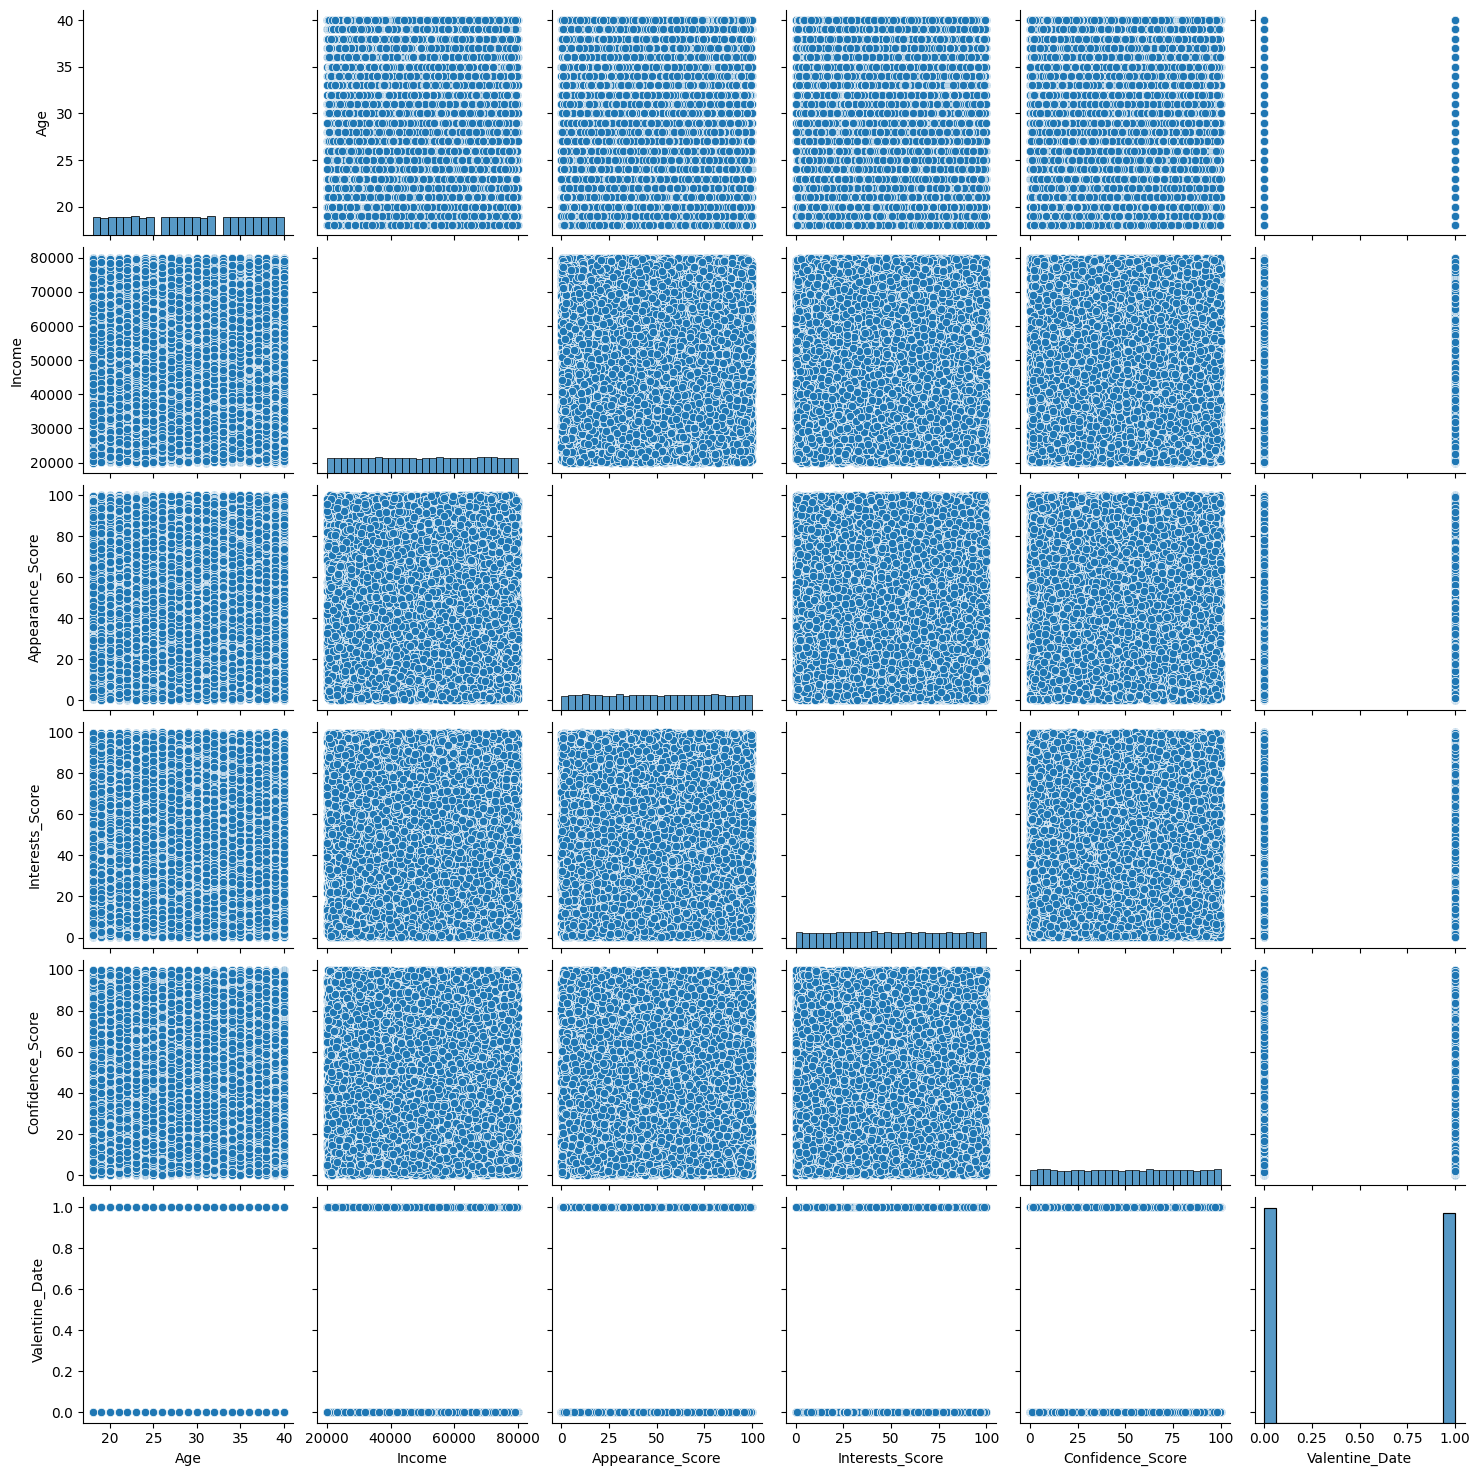

In [8]:
sns.pairplot(df[['Age', 'Income', 'Appearance_Score', 
                 'Interests_Score', 'Confidence_Score', 'Valentine_Date']])

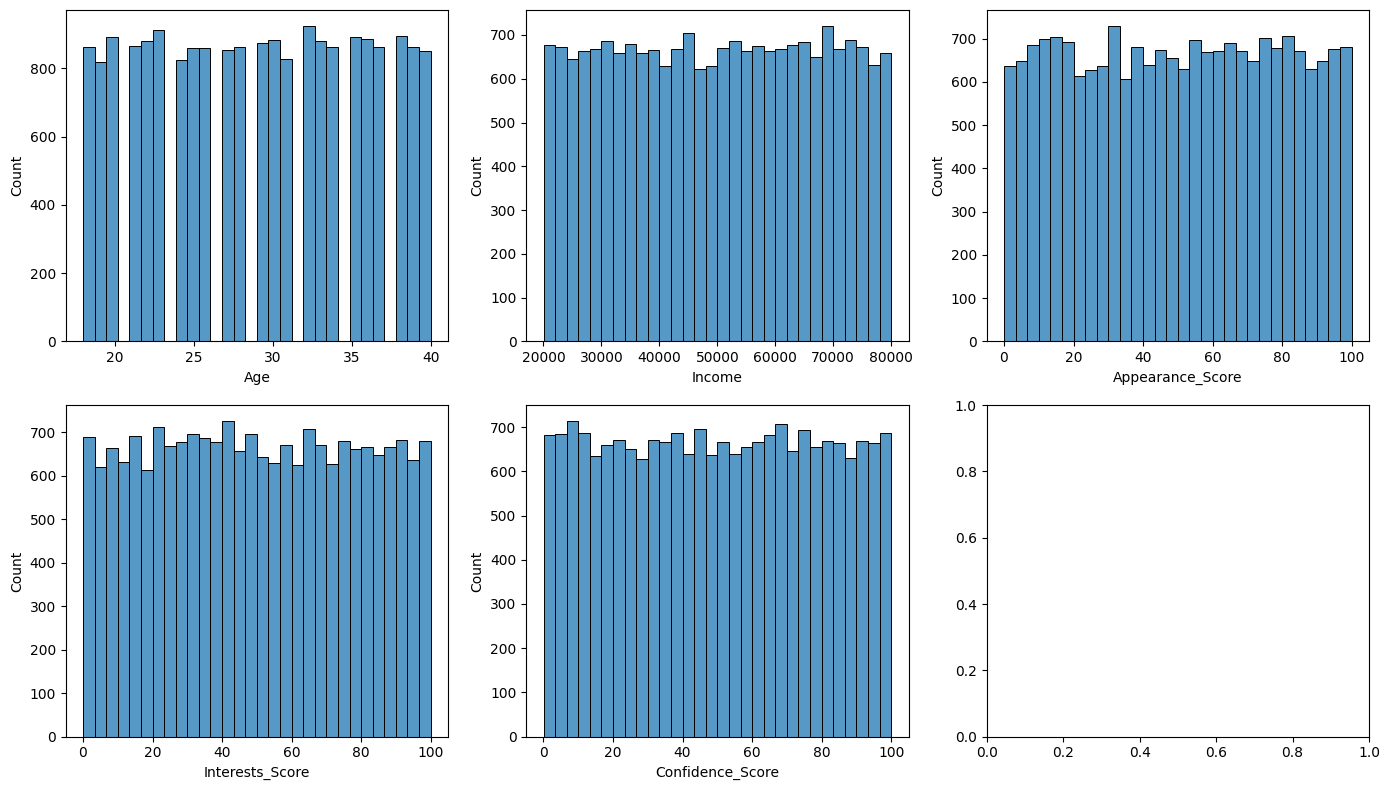

In [9]:
features = ['Age', 'Income', 'Appearance_Score', 'Interests_Score', 'Confidence_Score']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,8))

for idx, feature in enumerate(features):
    sns.histplot(df[feature], ax=axs[idx//3, idx%3], bins=30)
plt.tight_layout()
plt.show()

Видим, что все признаки распределены равномерно, датасет сбалансирован и не содержит выбросов

In [12]:
df.describe()

,Age,Income,Appearance_Score,Interests_Score,Confidence_Score,Valentine_Date
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,29.033800,50051.034150,50.136727,49.950643,49.913995,0.493300
std,6.622458,17329.779354,28.877615,28.774120,28.978751,0.499968
min,18.000000,20004.000000,0.000000,0.010000,0.010000,0.000000
25%,23.000000,35013.250000,25.070000,25.310000,24.807500,0.000000
50%,29.000000,50230.000000,50.320000,49.530000,49.960000,0.000000
75%,35.000000,65120.500000,75.222500,74.880000,74.950000,1.000000
max,40.000000,79998.000000,99.990000,100.000000,100.000000,1.000000


In [10]:
incomes = df['Income']
print(f'previous mean: {incomes.mean()}\tstd: {incomes.std()}')
income_centered_and_normalized = ((incomes - incomes.mean()) / incomes.std())
print(f'current mean: {income_centered_and_normalized.mean()}\tstd: {income_centered_and_normalized.std()}')
# df['Income'] = income_centered_and_normalized

previous mean: 50051.03415	std: 17329.779353996597
current mean: 2.842170943040401e-17	std: 0.9999999999999999


In [15]:
log_incomes = np.log10(incomes)
print(f'previous mean: {incomes.mean()}\tstd: {incomes.std()}')
print(f'previous mean: {log_incomes.mean()}\tstd: {log_incomes.std()}')

df['Income'] = log_incomes

previous mean: 50051.03415	std: 17329.779353996597
previous mean: 4.669887073352574	std: 0.1660638425030541


In [19]:
print(cat_features)
cat_features = cat_features[1:]
print(cat_features)

In [20]:
genders = pd.DataFrame(df['Gender'].value_counts())
for index in list(genders.index):
    print(f"{index}: {genders.loc[index].values[-1] / genders['count'].sum() * 100:.2f}%")

Male: 50.23%
Female: 49.77%


In [21]:
edu_status = pd.DataFrame(df['Educational_Status'].value_counts())
for index in list(edu_status.index):
    print(f"{index}: {edu_status.loc[index].values[-1] / edu_status['count'].sum() * 100:.2f}%")

High School: 25.54%
Bsc: 24.93%
PhD: 24.77%
Master: 24.77%


In [22]:
job_type = pd.DataFrame(df['Job_Type'].value_counts())
for index in list(job_type.index):
    print(f"{index}: {job_type.loc[index].values[-1] / job_type['count'].sum() * 100:.2f}%")

Employed: 50.07%
Self Employed: 49.93%


Видим, что все категориальные признаки сбалансированы

In [23]:
# let's transform categorical features into numeric via label encoder
gender_encoder = LabelEncoder()
gender = gender_encoder.fit_transform(df['Gender'])
print(df['Gender'].iloc[:3].values, gender[:3])
df['Gender'] = gender

['Male' 'Male' 'Male'] [1 1 1]


In [24]:
job_encoder = LabelEncoder()
jobs = job_encoder.fit_transform(df['Job_Type'])
print(df['Job_Type'].iloc[:3].values, jobs[:3])
df['Job_Type'] = jobs

['Employed' 'Employed' 'Employed'] [0 0 0]


In [55]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
education = df['Educational_Status'].unique()
for edu in education:
    df[edu] = np.where(df['Educational_Status'].values == edu, 1, 0)
df.drop(columns='Educational_Status', inplace=True)

In [27]:
df.head()

,Name,Age,Gender,Income,Appearance_Score,Interests_Score,Confidence_Score,Job_Type,Valentine_Date,Bsc,PhD,Master,High School
0,Leon Cruz,26,1,4.890130,63.94,88.18,30.09,0,1,1,0,0,0
1,Samuel Brown,23,1,4.855016,2.50,49.98,76.45,0,1,1,0,0,0
2,Lori Baker,34,1,4.586767,27.50,33.90,33.76,0,1,0,1,0,0
3,Tina Fitzgerald,37,1,4.900220,22.32,25.47,43.32,1,1,0,0,1,0
4,Jason Simmons,38,1,4.638589,73.65,43.63,32.44,0,0,1,0,0,0


---
# обучение модели логистической регрессии

only Numeric Features

In [28]:
X, y = df[num_features].values, df['Valentine_Date'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [29]:
log_reg = LogisticRegression(max_iter=10**4)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

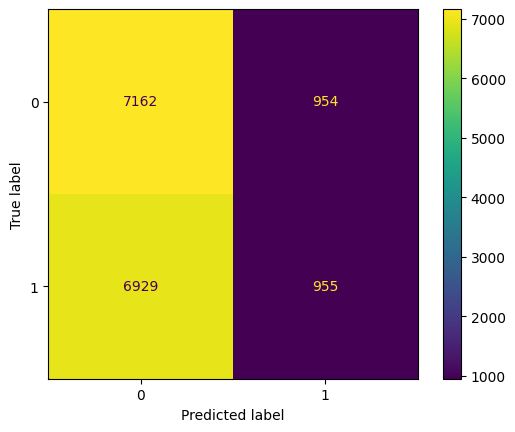

In [30]:
prediction = log_reg.predict(X_train)
cm = confusion_matrix(y_train, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [36]:
print(classification_report(y_train, prediction))

              precision    recall  f1-score   support

           0       0.52      0.84      0.64      8116
           1       0.54      0.19      0.28      7884

    accuracy                           0.52     16000
   macro avg       0.53      0.52      0.46     16000
weighted avg       0.53      0.52      0.46     16000



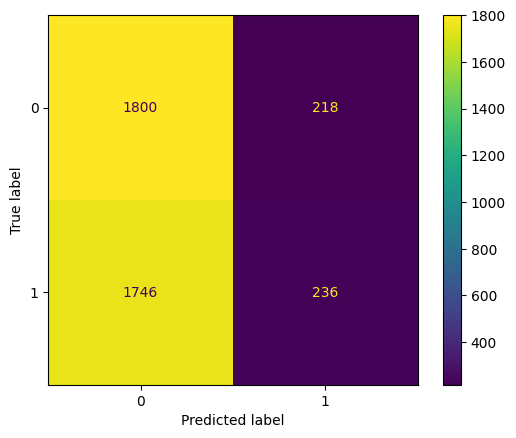

In [37]:
prediction = log_reg.predict(X_test)
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [39]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.51      0.89      0.65      2018
           1       0.52      0.12      0.19      1982

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.42      4000
weighted avg       0.51      0.51      0.42      4000



In [31]:
print(f'accuracy: {accuracy_score(y_train, prediction)}')
print(f'precision: {precision_score(y_train, prediction)}')

accuracy: 0.5073125
precision: 0.500261917234154


In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
dt_cl = DecisionTreeClassifier(max_depth=5)
dt_cl.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

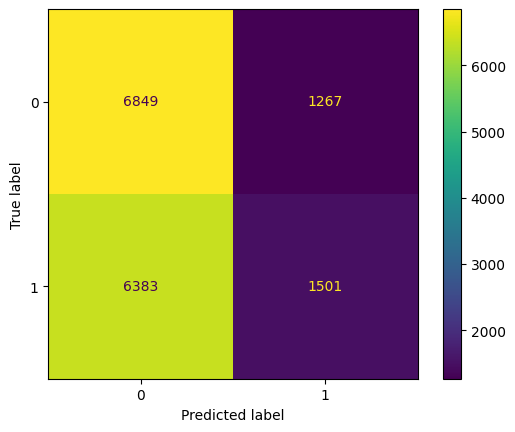

In [35]:
prediction = dt_cl.predict(X_train)
cm = confusion_matrix(y_train, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()